In [1]:
import pandas as pd
import numpy as np
import psycopg2

from passwords import password

In [2]:
hate_crime_df = pd.read_csv("../Datasets/hate_crime.csv", low_memory=False)
hate_crime_df.columns

Index(['INCIDENT_ID', 'DATA_YEAR', 'ORI', 'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT',
       'AGENCY_TYPE_NAME', 'STATE_ABBR', 'STATE_NAME', 'DIVISION_NAME',
       'REGION_NAME', 'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC',
       'INCIDENT_DATE', 'ADULT_VICTIM_COUNT', 'JUVENILE_VICTIM_COUNT',
       'TOTAL_OFFENDER_COUNT', 'ADULT_OFFENDER_COUNT',
       'JUVENILE_OFFENDER_COUNT', 'OFFENDER_RACE', 'OFFENDER_ETHNICITY',
       'VICTIM_COUNT', 'OFFENSE_NAME', 'TOTAL_INDIVIDUAL_VICTIMS',
       'LOCATION_NAME', 'BIAS_DESC', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE',
       'MULTIPLE_BIAS'],
      dtype='object')

In [3]:
hate_crime_df = hate_crime_df.fillna(np.nan).replace([np.nan], [None])

In [4]:
hate_crime_df["BIAS_DESC"] = hate_crime_df["BIAS_DESC"].str.replace(","," ")
hate_crime_df["OFFENSE_NAME"] = hate_crime_df["OFFENSE_NAME"].str.replace(","," ")
hate_crime_df["POPULATION_GROUP_DESC"] = hate_crime_df["POPULATION_GROUP_DESC"].str.replace(","," ")
hate_crime_df["PUB_AGENCY_UNIT"] = hate_crime_df["PUB_AGENCY_UNIT"].str.replace(","," ")
hate_crime_df["PUB_AGENCY_NAME"] = hate_crime_df["PUB_AGENCY_NAME"].str.replace(","," ")

* Creating two seperate dataframes as per the data model for 2 tables.

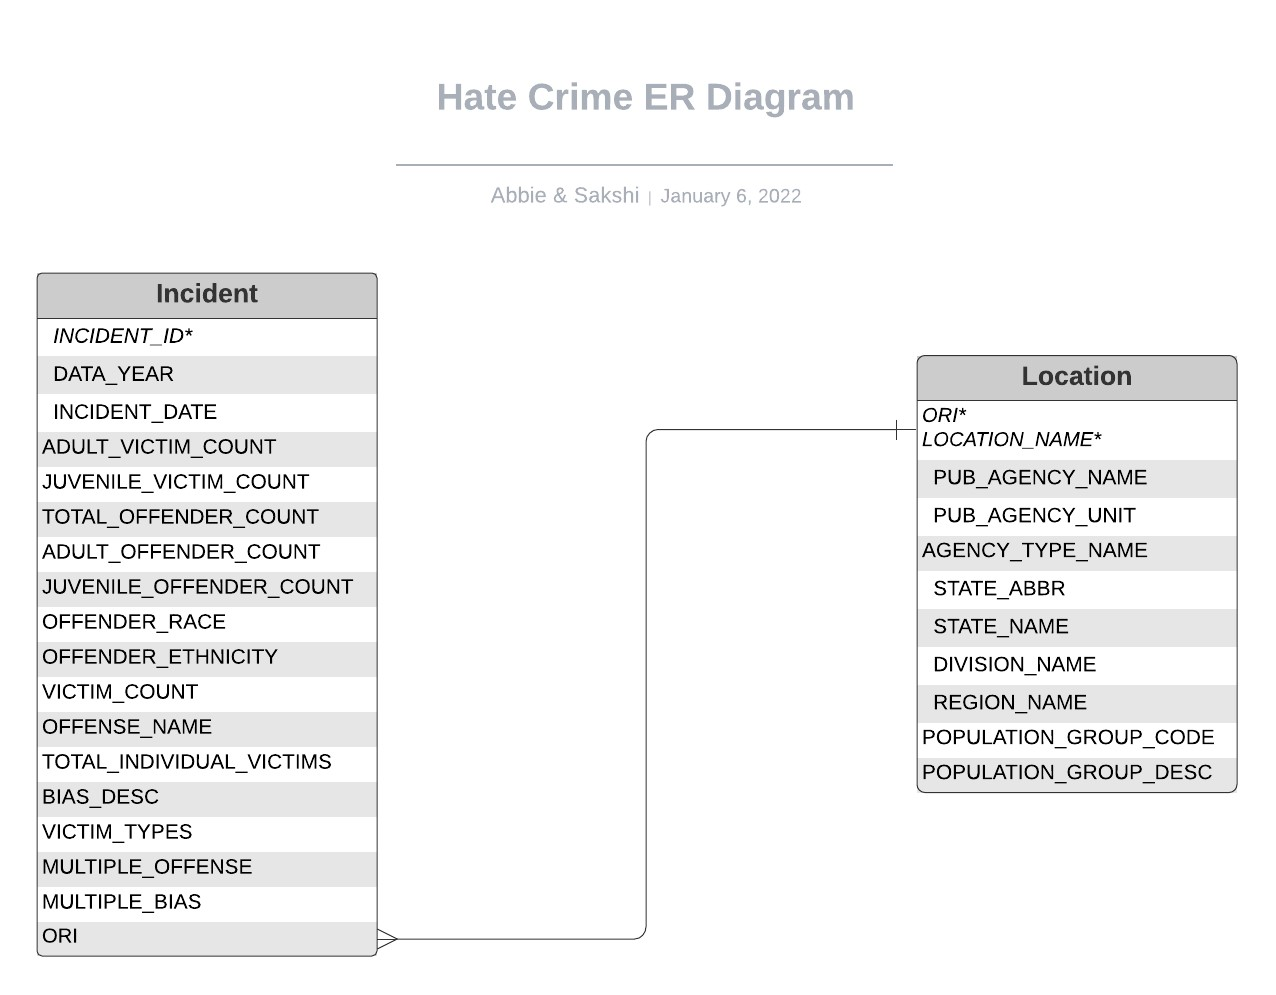

In [5]:
hc_incident_df = hate_crime_df[['INCIDENT_ID', 'DATA_YEAR',
       'INCIDENT_DATE', 'ADULT_VICTIM_COUNT', 'JUVENILE_VICTIM_COUNT',
       'TOTAL_OFFENDER_COUNT', 'ADULT_OFFENDER_COUNT',
       'JUVENILE_OFFENDER_COUNT', 'OFFENDER_RACE', 'OFFENDER_ETHNICITY',
       'VICTIM_COUNT', 'OFFENSE_NAME', 'TOTAL_INDIVIDUAL_VICTIMS',
       'BIAS_DESC', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE',
       'MULTIPLE_BIAS', 'ORI', 'LOCATION_NAME']]

hc_location_df = hate_crime_df[['ORI', 'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT', 'AGENCY_TYPE_NAME',
       'STATE_ABBR', 'STATE_NAME', 'DIVISION_NAME', 'REGION_NAME',
       'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC', 'LOCATION_NAME']]
hc_location_df = hc_location_df.drop_duplicates(subset=['ORI', 'LOCATION_NAME'], keep=False)

In [6]:
display(hc_incident_df.shape)
hc_location_df.shape

(219577, 19)

(23299, 11)

In [7]:
hc_incident_df.to_csv("incident.csv", index=False)
hc_location_df.to_csv("location.csv", index=False)

#### Creating database hate_crime

In [8]:
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password=password)

conn.autocommit = True

cursor = conn.cursor()

#Preparing query to create a database
sql = '''CREATE database hate_crime''';

#Creating a database
cursor.execute(sql)
print("Database created successfully........")

#Closing the connection
conn.close()

Database created successfully........


#### Creating table 'incident'

In [9]:
conn = psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password)

cursor = conn.cursor()

cursor.execute("""CREATE TABLE incident(
    INCIDENT_ID integer PRIMARY KEY,
    DATA_YEAR integer,  
    INCIDENT_DATE date, 
    ADULT_VICTIM_COUNT float,
    JUVENILE_VICTIM_COUNT float,
    TOTAL_OFFENDER_COUNT integer,  
    ADULT_OFFENDER_COUNT float,
    JUVENILE_OFFENDER_COUNT float,
    OFFENDER_RACE text, 
    OFFENDER_ETHNICITY text, 
    VICTIM_COUNT integer, 
    OFFENSE_NAME text,
    TOTAL_INDIVIDUAL_VICTIMS float,
    BIAS_DESC text, 
    VICTIM_TYPES text, 
    MULTIPLE_OFFENSE text, 
    MULTIPLE_BIAS text,
    ORI text
)
""")
conn.commit()
print("Table created")
conn.close()

Table created


#### Loading data into table incident from csv file

In [10]:
conn = psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password)

cursor = conn.cursor()

with open('incident.csv', 'r') as f:
    next(f) # Skip the header row.
    cursor.copy_from(f, 'incident', sep=',',null='')
    
conn.commit()
conn.close()

#### Creating table 'location'

In [11]:
conn = psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password)

cursor = conn.cursor()

cursor.execute("""CREATE TABLE location(
    ORI text NOT NULL,
    LOCATION_NAME text NOT NULL,
    PUB_AGENCY_NAME text,
    PUB_AGENCY_UNIT text,
    AGENCY_TYPE_NAME text,
    STATE_ABBR text,
    STATE_NAME text,
    DIVISION_NAME text,
    REGION_NAME text,
    POPULATION_GROUP_CODE text,
    POPULATION_GROUP_DESC text,
    CONSTRAINT location_id PRIMARY KEY (ORI,LOCATION_NAME)
)
""")
conn.commit()
print("Table created")
conn.close()

Table created


#### Loading data into table location from csv file

In [12]:
conn = psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password)

cursor = conn.cursor()

with open('location.csv', 'r') as f:
    next(f) # Skip the header row.
    cursor.copy_from(f, 'location', sep=',',null='')
    
conn.commit()
conn.close()

#### Running Queries now

##### checking for number incidents year wise order by descending total incidents

In [23]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT data_year, count(incident_id) AS incident_count
                FROM incident
                GROUP BY data_year 
                ORDER BY count(incident_id) DESC"""
    
    hc_per_year = pd.read_sql_query(query1,conn)

hc_per_year.head()

,data_year,incident_count
0,2020,10299
1,2001,9730
2,1996,8790
3,2000,8219
4,1997,8107


##### checking for number incidents state-wise with descending total incidents

In [24]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT l.state_name, count(i.incident_id) AS incident_count
                FROM incident as i 
                LEFT JOIN location as l 
                ON i.ori = l.ori 
                GROUP BY l.state_name 
                ORDER BY count(i.incident_id) DESC"""
    
    hc_per_state = pd.read_sql_query(query1,conn)

hc_per_state.head()

,state_name,incident_count
0,California,155643
1,New Jersey,87841
2,Michigan,61468
3,Washington,57068
4,Massachusetts,48947


##### Checking for incident count as per the population density

In [25]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT DISTINCT(population_group_code), population_group_desc, COUNT(incident_id) as incident_count
                FROM location as l 
                INNER JOIN incident as i
                ON l.ori = i.ori
                GROUP BY distinct(population_group_code), population_group_desc
                ORDER BY count(incident_id) DESC"""
    
    hc_per_pop_density = pd.read_sql_query(query1,conn)

hc_per_pop_density.head()

,population_group_code,population_group_desc,incident_count
0,3,Cities from 50 000 thru 99 999,129757
1,1B,Cities from 500 000 thru 999 999,125514
2,2,Cities from 100 000 thru 249 999,114922
3,4,Cities from 25 000 thru 49 999,107776
4,1A,Cities 1 000 000 or over,99419


##### Checking for case load across agency types

In [2]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT DISTINCT agency_type_name, COUNT(incident_id) as incident_count 
                FROM location l
                LEFT JOIN incident i
                ON l.ori = i.ori
                GROUP BY agency_type_name"""
    
    hc_per_agency_type = pd.read_sql_query(query1,conn)

hc_per_agency_type.head()

,agency_type_name,incident_count
0,City,793807
1,County,117813
2,Federal,1718
3,Other,1534
4,Other State Agency,356


##### Checking incident weightage by offender race recorded

In [5]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT offender_race, COUNT(incident_id) AS incident_count
                FROM incident
                GROUP BY offender_race 
                ORDER BY count(incident_id) DESC"""
    
    hc_by_offender_race = pd.read_sql_query(query1,conn)

hc_by_offender_race.head()

,offender_race,incident_count
0,Unknown,97334
1,White,86403
2,Black or African American,28507
3,Multiple,4423
4,Asian,1596


##### With California recorded the most cases, which year reported the most case there

In [10]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT data_year, count(incident_id) AS incident_count
                FROM incident as i
                LEFT JOIN location as l
                ON i.ori = l.ori
                WHERE state_name = 'California'
                GROUP BY data_year 
                ORDER BY count(incident_id) DESC;"""
    
    hc_cal_year = pd.read_sql_query(query,conn)

hc_cal_year.head()

,data_year,incident_count
0,2001,9456
1,1996,8809
2,1997,8264
3,1999,8203
4,2000,8128


##### With 2020 recorded the most cases, which state had the most case that year

In [11]:
with psycopg2.connect(host='localhost', dbname='hate_crime', user='postgres', password=password) as conn:

    query = """SELECT l.state_name, count(i.incident_id) AS incident_count
                FROM incident as i 
                LEFT JOIN location as l 
                ON i.ori = l.ori
                WHERE data_year = 2020
                GROUP BY l.state_name 
                ORDER BY count(i.incident_id) DESC;"""
    
    hc_2020_state_wise = pd.read_sql_query(query,conn)

hc_2020_state_wise.head()

,state_name,incident_count
0,New Jersey,5930
1,California,5448
2,Washington,3255
3,Ohio,3111
4,Texas,2118
